{N2pt, N3pt}={2,2} state fit: 7 parameters

Flow tau =  0.0
Points included for fit:  39

 M0 & M1 & A0^2 & A1^2 & A1^2/A0^2 & chi^2/DOF & AIC

0.4676(0085) & 0.8501(0048) & 5.18(38)e-10 & 4.09(82)e-10 & 1.2679(3428) & 2.4161(5697) & 91.316

  O00 & O01 & O11

& 1.5314(2883) & -0.6376(1605) & -1.3903(74847)




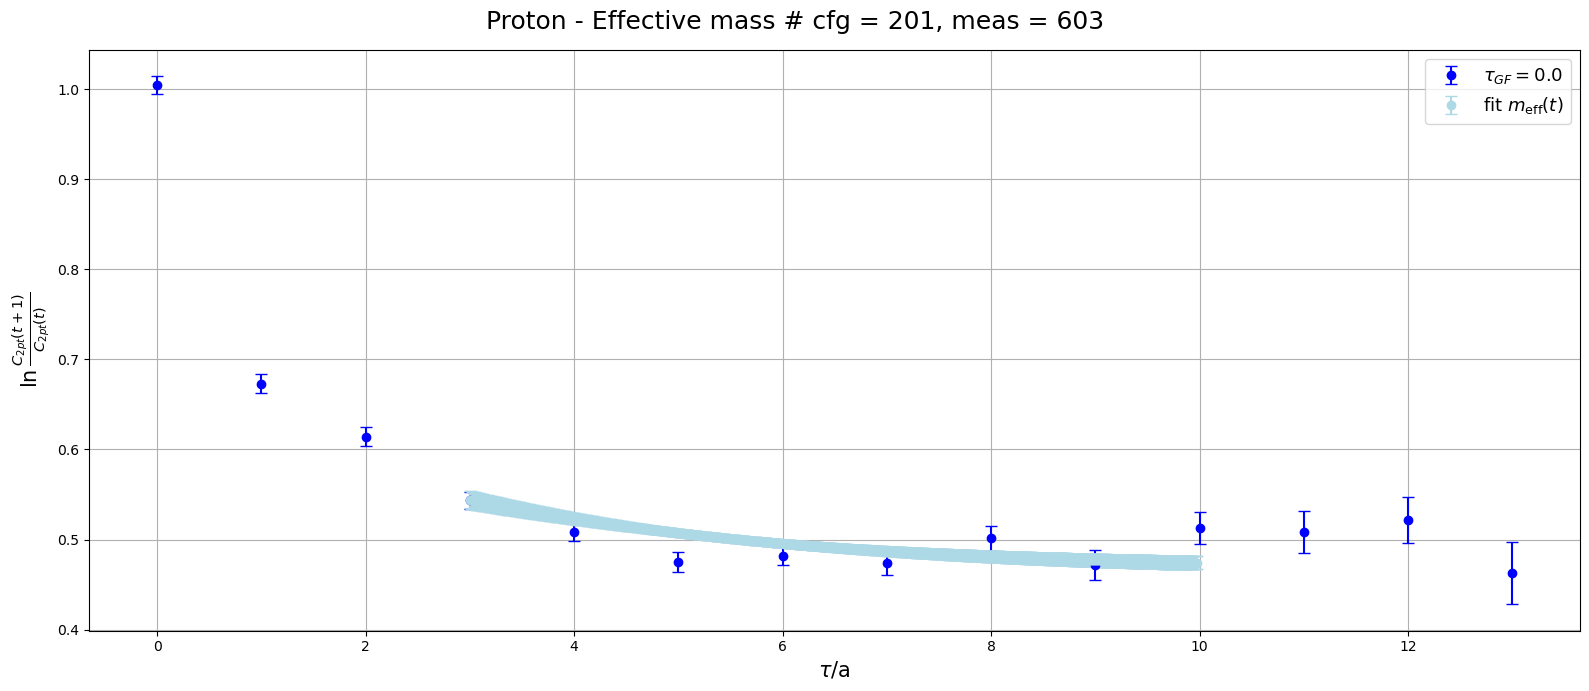

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gvar as gv
import lsqfit

cfglist = (
    pd.read_csv("/pscratch/sd/h/hari_8/production_nEDM_LANL/config_numbers.txt", header=None, dtype=str)  # 1-column DataFrame
      .squeeze("columns")                                      # -> Series
      .tolist()                                                # -> Python list
)


def fmt_err(mean, err):
    # switch to scientific if very small/big
    if mean and (abs(mean) < 1e-3 or abs(mean) >= 1e3):
        m_str = f"{mean:.2e}"           # e.g. "2.86e-08"
        mant, exp = m_str.split("e")
        ndec = len(mant.split(".")[1])  # digits in mantissa
        err_int = int(round(err / 10**int(exp) * 10**ndec))
        return f"{mant}({err_int})e{int(exp)}"
    else:
        ndec = 4                        # choose 4 decimal places
        m_str = f"{mean:.{ndec}f}"      # e.g. "0.4721"
        err_int = int(round(err * 10**ndec))
        return f"{m_str}({err_int:0{ndec}d})"
        
def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set

def give_jk_3pt(Num, Gn, WFt, snk_time, pt2_cfg):
    # Load 3pt data
    U_pt3_cfg = []
    D_pt3_cfg = []
    for j, cfg in enumerate(cfglist):
        U_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_U_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
    
        with h5py.File(U_file_path, "r") as h5_file: 
            U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
            U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
            U_values = U_observable_cfgb[Num][()]

        #t0x0y0z0_t21x10y10z10_t42x20y20z20
        U_pt3_data = np.array(U_values)
        U_pt3_data1 = U_pt3_data[0:(0+(snk_time+1))]
        U_pt3_data2 = U_pt3_data[21:(21+(snk_time+1))]
        U_pt3_data3 = U_pt3_data[42:(42+(snk_time+1))]
        U_pt3_cfg.append((U_pt3_data1+U_pt3_data2+U_pt3_data3)/3)
    
        D_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_D_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
    
        with h5py.File(D_file_path, "r") as h5_file: 
            D_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
            D_observable_cfgb = h5_file[D_path_to_observable_cfgb]
            D_values = D_observable_cfgb[Num][()]
    
        D_pt3_data = np.array(D_values)
        D_pt3_data1 = D_pt3_data[0:(0+(snk_time+1))]
        D_pt3_data2 = D_pt3_data[21:(21+(snk_time+1))]
        D_pt3_data3 = D_pt3_data[42:(42+(snk_time+1))]
        D_pt3_cfg.append((D_pt3_data1+D_pt3_data2+D_pt3_data3)/3)
    # Compute jackknife
    pt2_jackknifeset = Jackknifeset([pt2_cfg[i][(snk_time)] for i in range(len(pt2_cfg))])
    pt3bypt2_JK_value = []
    pt3bypt2_JK_err = []
    pt3_JK_value = []
    pt3_JK_err = []
    pt3_jackk_set = []
    for tau in range(snk_time+1):
        U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][tau] for i in range(len(U_pt3_cfg))])
        D_tau_Jackknifeset = Jackknifeset([D_pt3_cfg[i][tau] for i in range(len(D_pt3_cfg))])
        UD = (np.array(U_tau_Jackknifeset) - np.array(D_tau_Jackknifeset))
        pt3_JK_value_err = Jackknife(UD)
        UDby2pt = (np.array(U_tau_Jackknifeset) - np.array(D_tau_Jackknifeset)) / np.array(pt2_jackknifeset)
        pt3bypt2_JK_value_err = Jackknife(UDby2pt)
        
        pt3_jackk_set.append(UD)
        pt3_JK_value.append(pt3_JK_value_err[0])
        pt3_JK_err.append(pt3_JK_value_err[1])
        pt3bypt2_JK_value.append(pt3bypt2_JK_value_err[0])
        pt3bypt2_JK_err.append(pt3bypt2_JK_value_err[1])
    return(pt3_jackk_set, pt3_JK_value, pt3_JK_err, pt3bypt2_JK_value, pt3bypt2_JK_err)

     
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))

def C2_fit(tau, M0, A0, M1, A1):
    return A0**2*np.exp(-M0*tau) + A1**2*np.exp(-M1*tau)



def C3_fit(tau, M0, A0, M1, A1, O00, O01, O11, snk_time):
    exp0 = np.exp(-M0*(snk_time - tau) - M1*tau)
    exp1 = np.exp(-M1*(snk_time - tau) - M0*tau)

    return (A0*A0*O00 * np.exp(-M0*snk_time) + A0*A1*O01 * (exp0 + exp1) + A1*A1*O11 * np.exp(-M1*snk_time))

def fcn(x, p):
    # x is a dict: x['c2'], x['c3']
    t   = x['c2']
    taut8 = x['c3t8']
    taut10 = x['c3t10']
    taut12 = x['c3t12']
    taut14 = x['c3t14']
    M0, A0, M1, A1, O00, O01, O11 = (
        p['M0'], p['A0'], p['M1'], p['A1'],
        p['O00'], p['O01'], p['O11']
    )
    C2 = A0**2 * np.exp(-M0*t) + A1**2 * np.exp(-M1*t)

    C3t8 = C3_fit(taut8, M0, A0, M1, A1, O00, O01, O11, snk_time = 8)
    C3t10 = C3_fit(taut10, M0, A0, M1, A1, O00, O01, O11, snk_time = 10)
    C3t12 = C3_fit(taut12, M0, A0, M1, A1, O00, O01, O11, snk_time = 12)
    C3t14 = C3_fit(taut14, M0, A0, M1, A1, O00, O01, O11, snk_time = 14)

    return {'c2':C2, 'c3t8':C3t8, 'c3t10':C3t10, 'c3t12':C3t12, 'c3t14':C3t14}

# very loose priors
paramas = 7

def dofit(nocfg, data_samples, fit_ti_c2, fit_tf_c2, fit_ti_c3_t8, fit_tf_c3_t8, fit_ti_c3_t10, fit_tf_c3_t10, fit_ti_c3_t12, fit_tf_c3_t12, fit_ti_c3_t14, fit_tf_c3_t14):
    n2 = fit_tf_c2 - fit_ti_c2
    n3_t8 = fit_tf_c3_t8 - fit_ti_c3_t8
    n3_t10 = fit_tf_c3_t10 - fit_ti_c3_t10
    n3_t12 = fit_tf_c3_t12 - fit_ti_c3_t12
    n3_t14 = fit_tf_c3_t14 - fit_ti_c3_t14
    n_data = n2 + n3_t8 + n3_t10 + n3_t12 + n3_t14
    dof    = n_data - paramas
    fits_jk = np.zeros((nocfg, len(param_names)))
    chi2perdofjk = []
    chi2jk = []
    plotfit_c2 = []
    t_fine_c2 = np.arange(fit_ti_c2, fit_tf_c2, 0.01)
    plotfit_effm = []
    
    for jk in range(nocfg):
        # build a gvar y-vector for this jackknife sample
        y_jk = gv.gvar(data_samples[jk], cov)
        y_dict_jk = {'c2': y_jk[0:n2], 'c3t8': y_jk[n2:n2+n3_t8], 'c3t10': y_jk[n2+n3_t8:n2+n3_t8+n3_t10], 'c3t12': y_jk[n2+n3_t8+n3_t10:n2+n3_t8+n3_t10+n3_t12], 'c3t14': y_jk[n2+n3_t8+n3_t10+n3_t12:n2+n3_t8+n3_t10+n3_t12+n3_t14]}

        current_prior = {
          'M0':  gv.gvar(0.4721,    5*0.0025* np.random.uniform(0.8, 1.3)),
           'A0':  gv.gvar(1.691e-4,  5*2.7e-5* np.random.uniform(0.8, 1.3)),
           'M1':  gv.gvar(0.8510,    5*0.0028* np.random.uniform(0.8, 1.3)),
           'A1':  gv.gvar(1.847e-4,  5*3.5e-5* np.random.uniform(0.8, 1.3)),
           'O00': gv.gvar(1.5,     5*0.5* np.random.uniform(0.8, 1.5)),
           'O01': gv.gvar(0.5,   2* np.random.uniform(0.8, 1.5)),
           'O11': gv.gvar(0.5,   2* np.random.uniform(0.8, 1.5)),
         }
        # do the simultaneous correlated fit for this sample
        fit_jk = lsqfit.nonlinear_fit(
          data=(x_dict, y_dict_jk),
          prior=current_prior,
          fcn=fcn,
          debug=False,
          svdcut=1e-12
        )
        
        plotfit_c2.append(np.array([C2_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean) for t in np.arange(fit_ti_c2, fit_tf_c2, 0.01)]))
        
        
        C2_jk = plotfit_c2[-1]
        dt = t_fine_c2[1] - t_fine_c2[0]  # = 0.01
        effm_jk = np.log(C2_jk[:-1] / C2_jk[1:]) / dt
        plotfit_effm.append(effm_jk)

            
            
        # collect the *mean* values of each parameter
        fits_jk[jk] = [fit_jk.p[name].mean for name in param_names]
        chi2perdofjk.append(fit_jk.chi2 / (fit_jk.dof - paramas))
        chi2jk.append(fit_jk.chi2)

        
    chi2dof = fmt_err(Jackknife(chi2perdofjk)[0],Jackknife(chi2perdofjk)[1])
    aic = 2 * paramas + Jackknife(chi2jk)[0]
        
    A0sq_values = fits_jk[:, 1]
    A1sq_values = fits_jk[:, 3]
    mean_A1sqbyA0sq, err_A1sqbyA0sq = Jackknife(np.square(A0sq_values)/np.square(A1sq_values))
    def prlatx(pn, powr):
        return fmt_err(Jackknife(fits_jk[:, pn]**powr)[0], Jackknife(fits_jk[:, pn]**powr)[1])
            
    print("\n M0 & M1 & A0^2 & A1^2 & A1^2/A0^2 & chi^2/DOF & AIC\n")
    print(f"{prlatx(0, 1)} & {prlatx(2, 1)} & {prlatx(1, 2)} & {prlatx(3, 2)} & {fmt_err(mean_A1sqbyA0sq, err_A1sqbyA0sq)} & {chi2dof} & {aic:.3f}")
    print("\n  O00 & O01 & O11\n")
    print(f"& {prlatx(4, 1)} & {prlatx(5, 1)} & {prlatx(6, 1)}")

        

            
    meff_fit_mean = []
    meff_fit_err  = []
    for tttt in range(len(t_fine_c2)-1):
        arr = np.array([ plotfit_effm[jk][tttt] for jk in range(nocfg) ])
        m, e = Jackknife(arr)
        meff_fit_mean.append(m)
        meff_fit_err.append(e)
return (meff_fit_mean, meff_fit_err)



def plot_all_flows(Gn, Num, cfglist, fit_ti_c2, fit_tf_c2, fit_ti_c3_t8, fit_tf_c3_t8, fit_ti_c3_t10, fit_tf_c3_t10, fit_ti_c3_t12, fit_tf_c3_t12, fit_ti_c3_t14, fit_tf_c3_t14):
    #print("C2 Fit from t = ", fit_ti_c2 ," to ", fit_tf_c2-1,"\n")
    #print("C3 Fit from t = ", fit_ti_c3 ," to ", fit_tf_c3-1,"\n")
    #dofpluspara = (fit_tf_c2-fit_ti_c2)+(fit_tf_c3_t10-fit_ti_c3_t10)+1
    
    print("{N2pt, N3pt}={2,2} state fit: 7 parameters\n")
    
    flow_times = ["0p0"]#,"8p0", "12p5", "18p0"]
    tau_GF = [0]#, 8.0, 12.5, 18]
    colors = ['blue', 'green', 'red', 'purple']
    colorsfit = ['lightblue', 'lightgreen', 'lightcoral', 'plum']
    markers = ['o', 's', '^', 'D']

    fig3, ax3 = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        print("Flow tau = ", np.sqrt(8*tau_GF[i]))
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        pt2_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1

            # Load 2pt data
            
            pt2_file_path = "/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/hadspec.h5"
        
            with h5py.File(pt2_file_path, "r") as h5_file: 
                pt2_path_to_observable_cfgb = f"//proton.D-2389.DG7_6.DG7_6.SS/{WFt}_had_{cfg}"
                pt2_observable_cfgb = h5_file[pt2_path_to_observable_cfgb]
                pt2_values = pt2_observable_cfgb["re"][()]
            pt2_data = np.array(pt2_values)
            pt2_data1 = pt2_data[0:(0+(14+1))]
            pt2_data2 = pt2_data[21:(21+(14+1))]
            pt2_data3 = pt2_data[42:(42+(14+1))]
            pt2_cfg.append((pt2_data1+pt2_data2+pt2_data3)/3)

        # Compute jackknife
        pt2_JK_value = []
        pt2_JK_err = []
        pt2_jackk_set = []
        pt22ffmass_JK_value = []
        pt22ffmass_JK_err = []
        for tau in range(14):
            pt2_tau_Jackknifeset = Jackknifeset([pt2_cfg[i][tau] for i in range(len(pt2_cfg))])
            pt2_tau_1_Jackknifeset = Jackknifeset([pt2_cfg[i][tau+1] for i in range(len(pt2_cfg))])
            pt2ffmass_tau_Jackknifeset = np.log(pt2_tau_Jackknifeset)-np.log(pt2_tau_1_Jackknifeset)
            pt22ffmass_JK_value.append(Jackknife(np.array(pt2ffmass_tau_Jackknifeset))[0])
            pt22ffmass_JK_err.append(Jackknife(np.array(pt2ffmass_tau_Jackknifeset))[1])
            
            pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))
            pt2_jackk_set.append(pt2_tau_Jackknifeset)
            pt2_JK_value.append(pt2_JK_value_err[0])
            pt2_JK_err.append(pt2_JK_value_err[1])

         
        

  
            
        pt3_jackk_set_t8, pt3_JK_value_t8, pt3_JK_err_t8, pt3bypt2_JK_value_t8, pt3bypt2_JK_err_t8 = give_jk_3pt(Num, Gn, WFt, 8, pt2_cfg)
        pt3_jackk_set_t10, pt3_JK_value_t10, pt3_JK_err_t10, pt3bypt2_JK_value_t10, pt3bypt2_JK_err_t10 = give_jk_3pt(Num, Gn, WFt, 10, pt2_cfg)
        pt3_jackk_set_t12, pt3_JK_value_t12, pt3_JK_err_t12, pt3bypt2_JK_value_t12, pt3bypt2_JK_err_t12 = give_jk_3pt(Num, Gn, WFt, 12, pt2_cfg)
        pt3_jackk_set_t14, pt3_JK_value_t14, pt3_JK_err_t14, pt3bypt2_JK_value_t14, pt3bypt2_JK_err_t14 = give_jk_3pt(Num, Gn, WFt, 14, pt2_cfg)
        
        n2 = fit_tf_c2 - fit_ti_c2
        n3_t8 = fit_tf_c3_t8 - fit_ti_c3_t8
        n3_t10 = fit_tf_c3_t10 - fit_ti_c3_t10
        n3_t12 = fit_tf_c3_t12 - fit_ti_c3_t12
        n3_t14 = fit_tf_c3_t14 - fit_ti_c3_t14
        n_data = n2 + n3_t8 + n3_t10 + n3_t12 + n3_t14
        dof    = n_data - paramas
        print("Points included for fit: ", n_data )
    
        data_samples = np.zeros((nocfg, n2+n3_t8+n3_t10+n3_t12+n3_t14))
        for jk in range(nocfg):
            data_samples[jk, 0:n2]   = [pt2_jackk_set[t][jk]
                                       for t in range(fit_ti_c2, fit_tf_c2)]
            data_samples[jk, n2:n2+n3_t8]   = [pt3_jackk_set_t8[t][jk] for t in range(fit_ti_c3_t8, fit_tf_c3_t8)]
            data_samples[jk, n2+n3_t8:n2+n3_t8+n3_t10]   = [pt3_jackk_set_t10[t][jk] for t in range(fit_ti_c3_t10, fit_tf_c3_t10)]
            data_samples[jk, n2+n3_t8+n3_t10:n2+n3_t8+n3_t10+n3_t12]   = [pt3_jackk_set_t12[t][jk] for t in range(fit_ti_c3_t12, fit_tf_c3_t12)]
            data_samples[jk, n2+n3_t8+n3_t10+n3_t12:n2+n3_t8+n3_t10+n3_t12+n3_t14]   = [pt3_jackk_set_t14[t][jk] for t in range(fit_ti_c3_t14, fit_tf_c3_t14)]
            
    
        # jackknife covariance:
        mean_vec = data_samples.mean(axis=0)
        dev = data_samples - mean_vec
        cov = (nocfg-1)/nocfg * (dev.T @ dev)
        x_dict = {'c2': np.arange(fit_ti_c2, fit_tf_c2),'c3t8': np.arange(fit_ti_c3_t8, fit_tf_c3_t8),'c3t10': np.arange(fit_ti_c3_t10, fit_tf_c3_t10),'c3t12': np.arange(fit_ti_c3_t12, fit_tf_c3_t12),'c3t14': np.arange(fit_ti_c3_t14, fit_tf_c3_t14)}
        param_names = ['M0','A0','M1','A1','O00','O01','O11']
        
        fits_jk = np.zeros((nocfg, len(param_names)))

        chi2perdofjk = []
        chi2jk = []
        plotfit_c2 = []
        t_fine_c2 = np.arange(fit_ti_c2, fit_tf_c2, 0.01)
        plotfit_effm = []
        
        for jk in range(nocfg):
            # build a gvar y-vector for this jackknife sample
            y_jk = gv.gvar(data_samples[jk], cov)
            y_dict_jk = {'c2': y_jk[0:n2], 'c3t8': y_jk[n2:n2+n3_t8], 'c3t10': y_jk[n2+n3_t8:n2+n3_t8+n3_t10], 'c3t12': y_jk[n2+n3_t8+n3_t10:n2+n3_t8+n3_t10+n3_t12], 'c3t14': y_jk[n2+n3_t8+n3_t10+n3_t12:n2+n3_t8+n3_t10+n3_t12+n3_t14]}

            current_prior = {
              'M0':  gv.gvar(0.4721,    5*0.0025* np.random.uniform(0.8, 1.3)),
               'A0':  gv.gvar(1.691e-4,  5*2.7e-5* np.random.uniform(0.8, 1.3)),
               'M1':  gv.gvar(0.8510,    5*0.0028* np.random.uniform(0.8, 1.3)),
               'A1':  gv.gvar(1.847e-4,  5*3.5e-5* np.random.uniform(0.8, 1.3)),
               'O00': gv.gvar(1.5,     5*0.5* np.random.uniform(0.8, 1.5)),
               'O01': gv.gvar(0.5,   2* np.random.uniform(0.8, 1.5)),
               'O11': gv.gvar(0.5,   2* np.random.uniform(0.8, 1.5)),
             }
            # do the simultaneous correlated fit for this sample
            fit_jk = lsqfit.nonlinear_fit(
              data=(x_dict, y_dict_jk),
              prior=current_prior,
              fcn=fcn,
              debug=False,
              svdcut=1e-12
            )
            
            plotfit_c2.append(np.array([C2_fit(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean) for t in np.arange(fit_ti_c2, fit_tf_c2, 0.01)]))
            
            
            C2_jk = plotfit_c2[-1]
            dt = t_fine_c2[1] - t_fine_c2[0]  # = 0.01
            effm_jk = np.log(C2_jk[:-1] / C2_jk[1:]) / dt
            plotfit_effm.append(effm_jk)

            
            
            # collect the *mean* values of each parameter
            fits_jk[jk] = [fit_jk.p[name].mean for name in param_names]
            chi2perdofjk.append(fit_jk.chi2 / (fit_jk.dof - paramas))
            chi2jk.append(fit_jk.chi2)

        
        chi2dof = fmt_err(Jackknife(chi2perdofjk)[0],Jackknife(chi2perdofjk)[1])
        aic = 2 * paramas + Jackknife(chi2jk)[0]
        
        A0sq_values = fits_jk[:, 1]
        A1sq_values = fits_jk[:, 3]
        mean_A1sqbyA0sq, err_A1sqbyA0sq = Jackknife(np.square(A0sq_values)/np.square(A1sq_values))
        def prlatx(pn, powr):
            return fmt_err(Jackknife(fits_jk[:, pn]**powr)[0], Jackknife(fits_jk[:, pn]**powr)[1])
            
        print("\n M0 & M1 & A0^2 & A1^2 & A1^2/A0^2 & chi^2/DOF & AIC\n")
        print(f"{prlatx(0, 1)} & {prlatx(2, 1)} & {prlatx(1, 2)} & {prlatx(3, 2)} & {fmt_err(mean_A1sqbyA0sq, err_A1sqbyA0sq)} & {chi2dof} & {aic:.3f}")
        print("\n  O00 & O01 & O11\n")
        print(f"& {prlatx(4, 1)} & {prlatx(5, 1)} & {prlatx(6, 1)}")

        

            
        meff_fit_mean = []
        meff_fit_err  = []
        for tttt in range(len(t_fine_c2)-1):
            arr = np.array([ plotfit_effm[jk][tttt] for jk in range(nocfg) ])
            m, e = Jackknife(arr)
            meff_fit_mean.append(m)
            meff_fit_err.append(e)
        
        print("\n")
        time_plt = np.arange(len(pt2_JK_value))
        ax3.errorbar(time_plt, pt22ffmass_JK_value, yerr=pt22ffmass_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
        ax3.errorbar(t_fine_c2[:-1], meff_fit_mean, yerr=meff_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label='fit $m_{\\rm eff}(t)$')
        

    ax3.set_xlabel("$\\tau$/a", fontsize=15)
    ax3.set_ylabel("$\\ln{\\frac{C_{2pt}(t+1)}{C_{2pt}(t)}}$", fontsize=15)
    fig3.suptitle(f"Proton - Effective mass # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax3.tick_params(labelsize=10)
    ax3.grid(True)
    ax3.legend(fontsize=13)
    fig3.tight_layout()
    #fig1.savefig(f"pt2_pion_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig3.show() 

    


plot_all_flows(0, "re", cfglist,3, 10, 1, 7, 2, 6, 1, 11, 1, 13)